In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=816f23e04e83c5df92dfed48afc78c14efa5fe35cfdc2e338898350c074af7a3
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from PIL import Image
from pathlib import Path
from collections import Counter
import os
import shutil
import random


import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from minisom import MiniSom
from tqdm import tqdm
import cv2
import random
import math




In [25]:


base_path = '/content/drive/MyDrive/Deep Learning AOL'
original_dataset = os.path.join(base_path, 'ComprehensiveDisasterDataset')
target_root = os.path.join(base_path, 'disaster_dataset_clean')

train_dir = os.path.join(target_root, 'train')
test_dir = os.path.join(target_root, 'test')

target_classes = {
    'Earthquake': 'Earthquake',
    'Urban_Fire': 'Urban_Fire',
    'Land_Slide': 'Land_Slide',
    'Water_Disaster': 'Water_Disaster'
}


def clean_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)

clean_folder(train_dir)
clean_folder(test_dir)


def split_and_copy_images(class_name, src_folder, train_folder, test_folder, split_ratio=0.8):
    """Split images into train and test and copy them to target folders."""
    images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    n_train = int(len(images) * split_ratio)
    train_images = images[:n_train]
    test_images = images[n_train:]


    os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

    for img_name in tqdm(train_images, desc=f"Train - {class_name}"):
        src = os.path.join(src_folder, img_name)
        dst = os.path.join(train_folder, class_name, img_name)
        shutil.copy2(src, dst)


    for img_name in tqdm(test_images, desc=f"Test  - {class_name}"):
        src = os.path.join(src_folder, img_name)
        dst = os.path.join(test_folder, class_name, img_name)
        shutil.copy2(src, dst)

    return len(train_images), len(test_images)


print("Rebuilding train/test folders...\n")
total_train = 0
total_test = 0

for class_name, folder_name in target_classes.items():
    src_folder = os.path.join(original_dataset, folder_name)
    n_train, n_test = split_and_copy_images(class_name, src_folder, train_dir, test_dir)
    total_train += n_train
    total_test += n_test
    print(f"{class_name}: {n_train} train, {n_test} test")


print("\n=== Rebuild Summary ===")
print(f"Train folder: {train_dir}")
print(f"Test folder:  {test_dir}")
print(f"Total train images: {total_train}")
print(f"Total test images:  {total_test}")

print("\n✅ Train/Test folders have been successfully rebuilt.")


Rebuilding train/test folders...



Test  - Earthquake: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Earthquake: 28 train, 8 test


Test  - Urban_Fire: 100%|██████████| 84/84 [00:00<00:00, 92.14it/s]


Urban_Fire: 335 train, 84 test


Test  - Land_Slide: 100%|██████████| 92/92 [00:01<00:00, 76.34it/s]


Land_Slide: 364 train, 92 test


Test  - Water_Disaster: 100%|██████████| 207/207 [00:02<00:00, 88.38it/s]

Water_Disaster: 828 train, 207 test

=== Rebuild Summary ===
Train folder: /content/drive/MyDrive/Deep Learning AOL/disaster_dataset_clean/train
Test folder:  /content/drive/MyDrive/Deep Learning AOL/disaster_dataset_clean/test
Total train images: 1555
Total test images:  391

✅ Train/Test folders have been successfully rebuilt.


In [27]:
base_path = '/content/drive/MyDrive/Deep Learning AOL'

target_classes = {
    'Earthquake': 'ComprehensiveDisasterDataset/Earthquake',
    'Urban_Fire': 'ComprehensiveDisasterDataset/Urban_Fire',
    'Land_Slide': 'ComprehensiveDisasterDataset/Land_Slide',
    'Water_Disaster': 'ComprehensiveDisasterDataset/Water_Disaster'
}

print("total img / categories:")
for label, rel_path in target_classes.items():
    folder_path = os.path.join(base_path, rel_path)
    num_images = len(os.listdir(folder_path))
    print(f"- {label}: {num_images} image")


total img / categories:
- Earthquake: 36 image
- Urban_Fire: 419 image
- Land_Slide: 456 image
- Water_Disaster: 1035 image


In [28]:


def show_sample_images(class_name, rel_path, num_samples=5):
    folder_path = os.path.join(base_path, rel_path)
    image_files = os.listdir(folder_path)
    sample_imgs = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(15, 3))
    i = 1
    for fname in sample_imgs:
        img_path = os.path.join(folder_path, fname)

        img = Image.open(img_path)
        plt.subplot(1, num_samples, i)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
        i += 1

    plt.tight_layout()
    plt.show()


for label, path in target_classes.items():
    show_sample_images(label, path)



Output hidden; open in https://colab.research.google.com to view.

In [7]:
## Extracting & preparing features for SOM

In [29]:


DATA_DIR = '/content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/train'
categories = ['Earthquake', 'Land_Slide', 'Urban_Fire', 'Water_Disaster']

model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_feature(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat.flatten()







In [30]:

features = []
img_paths = []
labels = []

for category in categories:
    folder = os.path.join(DATA_DIR, category)
    for fname in tqdm(os.listdir(folder), desc=f'Extracting {category}'):
        fpath = os.path.join(folder, fname)
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            feat = extract_feature(fpath)
            features.append(feat)
            img_paths.append(fpath)
            labels.append(category)

features = np.array(features)
print(f"Total images processed: {len(features)}")

som_x, som_y = 20, 20
som = MiniSom(x=som_x, y=som_y, input_len=features.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(features)
som.train_random(data=features, num_iteration=1000)
print("SOM training complete.")

Extracting Water_Disaster: 100%|██████████| 828/828 [01:19<00:00, 10.37it/s]


Total images processed: 1555
SOM training complete.


In [31]:

distances = []
for x in features:
    bmu = som.winner(x)
    bmu_weight = som._weights[bmu]
    dist = np.linalg.norm(x - bmu_weight)
    distances.append(dist)

distances = np.array(distances)


threshold = distances.mean() + 2 * distances.std()
outlier_idx = np.where(distances > threshold)[0]

print(f"Detected {len(outlier_idx)} outliers out of {len(features)} images.")

Detected 32 outliers out of 1555 images.


In [ ]:
# seems mostly normal, lets try visualize the self organizing map and do manual inspection & cleaning

In [32]:

def show_outliers(indices, max_display=20):
    n_display = min(len(indices), max_display)
    if n_display == 0:
        print("no outliers found.")
        return

    n_cols = 5
    n_rows = (n_display + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for i, idx in enumerate(indices[:n_display]):
        img = image.load_img(img_paths[idx], target_size=(224, 224))
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{labels[idx]}\nDist={distances[idx]:.2f}", fontsize=9)

    plt.tight_layout()
    plt.show()

show_outliers(outlier_idx, max_display=20)

Output hidden; open in https://colab.research.google.com to view.


 Processing Category: Land_Slide
Total images: 364


Extracting features: 100%|██████████| 364/364 [00:36<00:00,  9.88it/s]


Feature shape: (364, 2048)
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 22.443034805179828


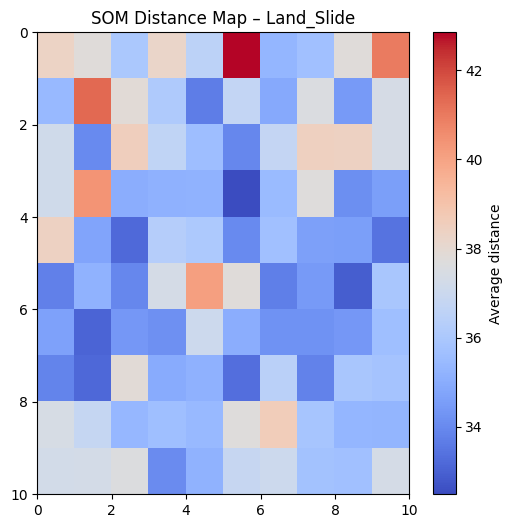

Detected outliers: 10


In [46]:

base_path = '/content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/train'
category = 'Land_Slide'   # CHANGE TO OTHER CATEGORY IF WANT TO VIEW THEM
class_path = os.path.join(base_path, category)
image_paths = [os.path.join(class_path, fname) for fname in os.listdir(class_path)]

print(f"\n Processing Category: {category}")
print(f"Total images: {len(image_paths)}")


model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
def extract_features(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat.flatten()

features = np.array([extract_features(p) for p in tqdm(image_paths, desc="Extracting features")])
print("Feature shape:", features.shape)

# TRAINING SOM
som_x, som_y = 10, 10
som = MiniSom(som_x, som_y, features.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(features)
som.train_random(features, 500, verbose=True)


node_distances = np.zeros((som_x, som_y))
for i in range(som_x):
    for j in range(som_y):
        node_weight = som.get_weights()[i, j]
        d = np.linalg.norm(features - node_weight, axis=1)
        node_distances[i, j] = np.mean(d)

plt.figure(figsize=(6, 6))
plt.title(f"SOM Distance Map – {category}")
plt.pcolor(node_distances, cmap='coolwarm')
plt.colorbar(label='Average distance')
plt.gca().invert_yaxis()
plt.show()


bmu_positions = np.array([som.winner(x) for x in features])
distances = np.array([np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in features])


threshold = distances.mean() + 2 * distances.std()
outlier_indices = np.where(distances > threshold)[0]
print(f"Detected outliers: {len(outlier_indices)}")



=== Manual SOM Node Checker ===
Type node coordinates (x y) to see node content.
Example: 3 7  |  Type 'o' to see automatic outliers | 'q' to quit.

Coordinates / command: 2 8
Node (2,8) contains 3 images.


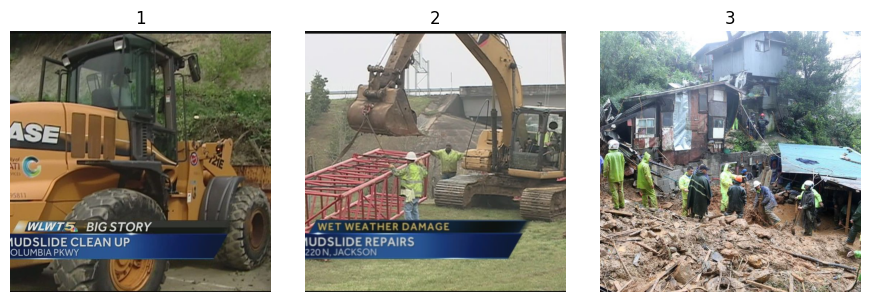

Image numbers to move (e.g., 1 3), or press Enter to skip: 1 2
→ Image no.1 (04_01_0267.png) moved to /content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/train_outlier/Land_Slide/
→ Image no.2 (04_01_0355.png) moved to /content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/train_outlier/Land_Slide/
Coordinates / command: q


In [49]:

# folder to store outlier images
train_outlier_dir = '/content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/train_outlier/Land_Slide/' #change this according to categories
os.makedirs(train_outlier_dir, exist_ok=True)

def show_images(indices):

    if not indices:
        print("no image in here.")
        return
    n = len(indices)
    cols = min(5, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, idx in enumerate(indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.1)

def move_selected_images(indices):
    """Ask which images to move to train_outlier, then move them."""
    if not indices:
        return

    choice = input("Image numbers to move (e.g., 1 3), or press Enter to skip: ").strip()
    if choice == "":
        print("No images moved.")
        return

    try:
        selected_nums = list(map(int, choice.split()))
        for num in selected_nums:
            if 1 <= num <= len(indices):
                idx = indices[num-1]
                src = image_paths[idx]
                filename = os.path.basename(src)
                dst = os.path.join(train_outlier_dir, filename)
                shutil.move(src, dst)
                print(f"→ Image no.{num} ({filename}) moved to {train_outlier_dir}")
            else:
                print(f"Number {num} is not valid.")
    except Exception as e:
        print(f"Error occurred while moving images: {e}")

print("\n=== Manual SOM Node Checker ===")
print("Type node coordinates (x y) to see node content.")
print("Example: 3 7  |  Type 'o' to see automatic outliers | 'q' to quit.\n")

while True:
    inp = input("Coordinates / command: ").strip()
    if inp.lower() == 'q':
        break
    elif inp.lower() == 'o':
        if len(outlier_indices) == 0:
            print("No outliers detected.")
            continue
        show_images(outlier_indices)
        move_selected_images(outlier_indices)
    else:
        try:
            x_node, y_node = map(int, inp.split())
            node_indices = [i for i, b in enumerate(bmu_positions) if tuple(b) == (x_node, y_node)]
            print(f"Node ({x_node},{y_node}) contains {len(node_indices)} images.")
            if len(node_indices) > 0:
                show_images(node_indices)
                move_selected_images(node_indices)
        except Exception as e:
            print(f"Wrong format or error: {e}. Example: 4 6 or 'o' or 'q'.")


In [ ]:
# SPLIT DATASET VAL (10% FROM TRAIN)

In [50]:

base_path = '/content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean'
train_path = os.path.join(base_path, 'train')
val_path   = os.path.join(base_path, 'val')


os.makedirs(val_path, exist_ok=True)
val_ratio = 0.10


for category in os.listdir(train_path):
    category_train_dir = os.path.join(train_path, category)
    category_val_dir = os.path.join(val_path, category)

    if not os.path.isdir(category_train_dir):
        continue

    os.makedirs(category_val_dir, exist_ok=True)
    images = [f for f in os.listdir(category_train_dir)
              if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]


    random.shuffle(images)

    n_val = max(1, int(len(images) * val_ratio))

    val_images = images[:n_val]

    print(f"{category}: movving {n_val} images to val from total {len(images)}")
    for img_name in val_images:
        src = os.path.join(category_train_dir, img_name)
        dst = os.path.join(category_val_dir, img_name)
        shutil.move(src, dst)

print("\n Folder val is available.")


Earthquake: movving 2 images to val from total 28
Urban_Fire: movving 32 images to val from total 327
Land_Slide: movving 32 images to val from total 326
Water_Disaster: movving 80 images to val from total 805

 Folder val is available.


## TRAINING

# Augmentation & Resize


In [52]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random

IMG_SIZE = 224
BATCH_SIZE = 32
train_path = '/content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/train'
val_path   = '/content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/val'


def random_augment(img):
    h, w = img.shape[:2]
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
    if random.random() < 0.5:
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    if random.random() < 0.5:
        alpha = random.uniform(0.8, 1.2)
        beta  = random.uniform(-30, 30)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img

def earthquake_augment(img):
    h, w = img.shape[:2]
    if random.random() < 0.7:
        img = cv2.flip(img, 1)
    if random.random() < 0.7:
        angle = random.uniform(-25, 25)
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    if random.random() < 0.7:
        alpha = random.uniform(0.7, 1.3)
        beta  = random.uniform(-40, 40)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img


class DisasterDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.samples = []
        self.classes = sorted(os.listdir(img_dir))
        self.class_indices = {c:i for i,c in enumerate(self.classes)}

        for cls in self.classes:
            cls_dir = os.path.join(img_dir, cls)
            if os.path.isdir(cls_dir):
                for fname in os.listdir(cls_dir):
                    if fname.lower().endswith(('.jpg','.jpeg','.png','.bmp')):
                        self.samples.append((os.path.join(cls_dir, fname), cls))

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)

    def __getitem__(self, index):
        batch_samples = self.samples[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_samples), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_samples), len(self.classes)), dtype=np.float32)

        for i, (img_path, cls) in enumerate(batch_samples):
            img = cv2.imread(img_path)
            if img is None:
                continue
            if len(img.shape) == 2 or img.shape[2] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))

            if cls.lower() == 'earthquake':
                img = earthquake_augment(img)
            else:
                img = random_augment(img)

            # Preprocessing EfficientNet
            img = tf.keras.applications.efficientnet.preprocess_input(img)
            X[i] = img
            y[i, self.class_indices[cls]] = 1.0

        return X, y

train_gen = DisasterDataGenerator(train_path, batch_size=BATCH_SIZE)
val_gen   = DisasterDataGenerator(val_path, batch_size=BATCH_SIZE, shuffle=False)


In [56]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import tensorflow as tf

# === 3. Model EfficientNetB0 ===
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

#unfreeze layer
for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    # layers.Dropout(0.4),
    layers.Dense(len(train_gen.classes), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [57]:

EPOCHS = 12

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 280s 5s/step - accuracy: 0.5359 - loss: 1.1474 - val_accuracy: 0.8286 - val_loss: 0.5427
Epoch 2/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 390ms/step - accuracy: 0.8803 - loss: 0.4590 - val_accuracy: 0.8857 - val_loss: 0.3664
Epoch 3/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 395ms/step - accuracy: 0.9057 - loss: 0.3055 - val_accuracy: 0.9214 - val_loss: 0.2892
Epoch 4/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 397ms/step - accuracy: 0.9205 - loss: 0.2244 - val_accuracy: 0.9107 - val_loss: 0.2638
Epoch 5/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 410ms/step - accuracy: 0.9358 - loss: 0.1690 - val_accuracy: 0.9286 - val_loss: 0.2561
Epoch 6/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - accuracy: 0.9648 - loss: 0.1197 - val_accuracy: 0.9321 - val_loss: 0.2614
Epoch 7/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - accuracy: 0.9624 - loss: 0.1043 - val_accuracy: 0.9321 - val_loss: 0.2475
Epoch 8/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 396ms/step - accuracy: 0.9675 - loss: 0.0950 - val_accura

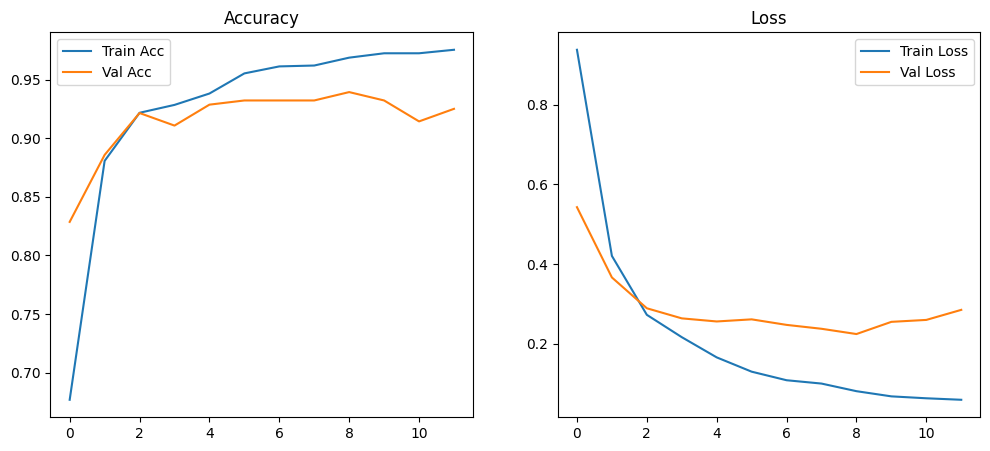

In [58]:


# === 5. Plot training ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


Found 391 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
=== Classification Report ===
                precision    recall  f1-score   support

    Earthquake     0.0000    0.0000    0.0000         8
    Land_Slide     0.7708    0.8043    0.7872        92
    Urban_Fire     1.0000    0.8333    0.9091        84
Water_Disaster     0.9050    0.9662    0.9346       207

      accuracy                         0.8798       391
     macro avg     0.6690    0.6510    0.6577       391
  weighted avg     0.8753    0.8798    0.8753       391



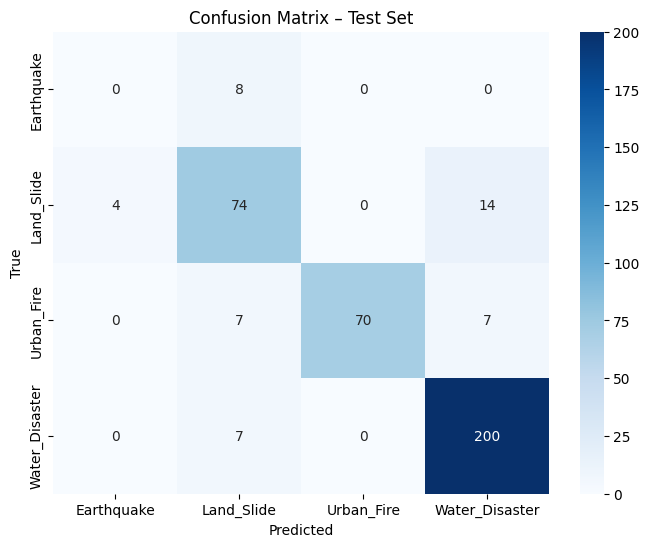

In [59]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


test_dir = '/content/drive/My Drive/Deep Learning AOL/disaster_dataset_clean/test'

IMG_SIZE = 224
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes


class_labels = list(test_gen.class_indices.keys())
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Test Set')
plt.show()


In [ ]:
# # RESULT efficientNet (IMAGE NET)
# Test Accuracy: 81.59%
# Confusion Matrix:
# [[  4   3   0   1]
#  [ 14  66   4   8]
#  [  2   9  71   2]
#  [  6  17   6 178]]
# Classification Report:
#                 precision    recall  f1-score   support

#     Earthquake       0.15      0.50      0.24         8
#     Land_Slide       0.69      0.72      0.71        92
#     Urban_Fire       0.88      0.85      0.86        84
# Water_Disaster       0.94      0.86      0.90       207

#       accuracy                           0.82       391
#      macro avg       0.67      0.73      0.68       391
#   weighted avg       0.85      0.82      0.83       391